<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3d_OSI_SAF_sea_ice_mapping_Ice_Drift.ipynb" target="_blank"><< Mapping OSI SAF sea ice type</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href=".1_3f_OSI_SAF_sea_ice_plotting_Ice_Index.ipynb" target="_blank">Plotting OSI SAF sea ice index >></a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sea-ice/HEAD?urlpath=%2Ftree%2F1_OSI_SAF_sea_ice_introductory%2F1_3d_OSI_SAF_sea_ice_mapping_ice_drift.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea ice parameters : Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb" target="_blank">1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb</a>**

</div>
<hr>

# 1.3e Mapping OSI SAF sea ice emissivity 
### Data used 

| Dataset | EUMETSAT collection ID | OSI SAF website description | OSI SAF identifier |
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| Global Sea Ice Emissivity | EO:EUM:DAT:DMSP:SISE50 | <a href="https://osi-saf.eumetsat.int/products/osi-404-a" target="_blank">Description</a> | OSI-404-a |  


### Learning outcomes

At the end of this notebook you will know;
* How to open Sea Ice Emissivity netcdf
* Map Sea Ice Emissivity using cartopy 

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Mapping sea ice emissitivty - Northern Hemisphere](#section1)
 2. [Mapping sea ice emissitivty - Southern Hemisphere](#section2)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports 
import os                          # a library that allows us access to basic operating system commands
import xarray as xr                # a library that supports the use of multi-dimensional arrays in Python
import matplotlib as mpl           # a library for visualization
import matplotlib.pyplot as plt    # a library that supports plotting
import matplotlib.cm as mpl_cm     # a part of the plotting library that provides colour maps
import cartopy.crs as ccrs         # a mapping library that supports reprojection
import cartopy.feature as cfeature # a part of the mapping library that provides features such as coastlines
import cmocean                     # colormaps for ocean products
import cmcrameri                   # scientific colormaps for data visualisation
import numpy as np                 # a library that supports array manipulation
import urllib                      # a library that helps us read in remote resources from URLs
from PIL import Image              # a library that helps us plot images
from netCDF4 import Dataset        # a library that helps us open netCDF files
import warnings                    # a library that controls python warnings

warnings.filterwarnings('ignore')

##
<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. Supporting functions
[Back to top](#TOC-TOP)

</div>

Before we begin, we will define shorts functions.

The function name `mapping_ice_emi` create a plot figure of sea ice concentration product available in the directory **directory** with a specific output projection and a specific region of the globe if given.

In [2]:
def mapping_ice_emi(directory, output_projection, type, cmap, ax=None, title="", region=None):
    """
        Function to map Sea Ice Emissivity. 

        Args:
            directory (string)  : the directory where files are
            output_projection   : the output projection to plot map
            type (string)       : plot type
            cmap                : color palette
            ax                  : axes of the plot
            region (list)       : the region to zoom in. If not region is given, plot a global map
            title (string)      : title of the plot
        Returns:
            im                  : the plotting figure

    """
    # set data projection and request output projection
    data_projection=ccrs.PlateCarree()

    # define plot carateristics
    if not ax: ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
    if region: ax.set_extent(region, crs=data_projection)
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
    ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
    ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
    ax.coastlines()    # Add coastline

    # Add title
    plt.title(title, fontsize=18)

    # open and plot data
    for filename in os.listdir(directory):
        if filename.endswith(".nc"):
            nc = xr.open_dataset(os.path.join(directory, filename))
            xc = nc.variables['xc'][:] 
            yc = nc.variables['yc'][:] 
            lat = nc.variables['lat'][:]   
            lon = nc.variables['lon'][:]
            if type=='ev' : var = nc.variables['ev'][:]
            if type=='e' : var = nc.variables['e'][:]
            if type=='R' : var = nc.variables['R'][:]
            if type=='S' : var = nc.variables['S'][:]
            nc.close()
    
            # plotting sea ice emissivity
            im = ax.pcolormesh(lon,lat,var, transform=data_projection,cmap=cmap)
            
            im.set_clim(0.5,1)
    return im

The function name `add_colorbar` create a colorbar of the image im.

In [3]:
def add_colorbar(im, fig, orientation, cmap, label='', discrete=False, extend='neither'):
    """
    Function to add a colormap. 

    Args:
        im                         : image
        fig                        : figure
        orientation (string)       : the orientation of colorbar (horizontal or vertical)
        cmap                       : color palette
        dicrete (bool)             : add discrete color
        extend                     : extension type of the colorbar (neither, max, min or both) 

    """
    
    if orientation == 'horizontal':
        axc = fig.add_axes((0.05,0.1,0.75,0.02))
        ax = fig.add_axes([0.38,0.12,0.1,0.05], anchor='S', zorder=-1 )
    else :
        axc = fig.add_axes((0.8,0.05,0.02,0.8))
        ax = fig.add_axes([0.7,.85,0.2,0.05], anchor='S', zorder=-1 )
    if discrete:
        bounds = range(int(im.get_clim()[0]),int(im.get_clim()[1]))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds)
    else:
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend)
    
    url = "https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSISAF_Name_Colour.png"
    logo = np.array(Image.open(urllib.request.urlopen(url)))
        
    ax.imshow(logo)
    ax.axis('off')
    cb.set_label(label, fontsize=18)
    cb.ax.tick_params(labelsize=14)

##
<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Mapping sea ice emissitivty - Northern Hemisphere
[Back to top](#TOC-TOP)

</div>

Setting directory where to read data files

In [4]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_emissivity', 'nh')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [5]:
#cmap = cmocean.cm.ice
#cmap = cmcrameri.cm.oslo
cmap = mpl_cm.get_cmap('RdYlGn_r')

Sea Ice Drift data has a specific projection. We can explore the netcdf file to find the characteristics.

In [6]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [7]:
nc

<xarray.Dataset> Size: 31MB
Dimensions:                   (xc: 760, yc: 1120)
Coordinates:
  * xc                        (xc) float64 6kB -3.845e+06 ... 3.735e+06
  * yc                        (yc) float64 9kB 5.835e+06 ... -5.345e+06
    lon                       (yc, xc) float32 3MB ...
    lat                       (yc, xc) float32 3MB ...
Data variables:
    Polar_Stereographic_Grid  int32 4B ...
    flag                      (yc, xc) float32 3MB ...
    R                         (yc, xc) float32 3MB ...
    S                         (yc, xc) float32 3MB ...
    ev                        (yc, xc) float32 3MB ...
    e                         (yc, xc) float32 3MB ...
    u                         (yc, xc) float32 3MB ...
    teff                      (yc, xc) float32 3MB ...
Attributes: (12/30)
    title:                   The near 50GHz sea ice emissivity
    institution:             The EUMETSAT Ocean and Sea Ice Satellite Applica...
    product_id:              OSI-404
    product_name:            osi_saf_ice_emis
    product_status:          operational
    abstract:                The sea ice surface emissivity is representative...
    ...                      ...
    references:              http://osisaf.met.no\n http://www.osi-saf.org
    history:                 2023-02-01 creation
    product_version:         1.4
    software_version:        5.0.1
    netcdf_version:          3.6.3
    Conventions:             CF-1.5

With Sea Ice Emisivity data file, It is possible to plot 4 types of variables :
* The nadir 50GHz emissivity : e
* The 50GHz vertically polarised emissivity at 50 deg incidence angle : ev
* R coefficient describing the polarisation
* S coefficient describing the nadir emissivity

### Map 50GHz vertically polarised emissivity at 50 deg incidence angle

Let's Map the 50GHz vertically polarised emissivity at 50 deg incidence angle

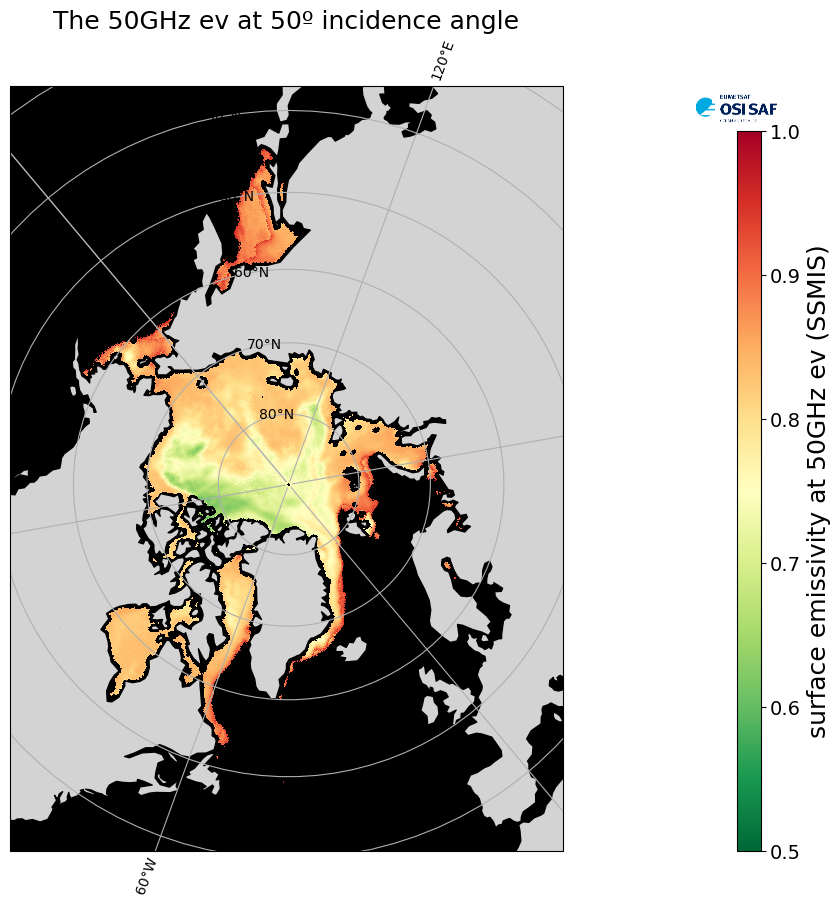

In [8]:
fig = plt.figure(figsize=(12,9))

# request output projection
output_projection=ccrs.NorthPolarStereo(-40)

# Map Emissivity
im = mapping_ice_emi(directory, 
                     output_projection, 
                     'ev', 
                     cmap, 
                     title="The 50GHz ev at 50º incidence angle")

# Add a colorbar
add_colorbar(im, fig, orientation='vertical', cmap=cmap, label='surface emissivity at 50GHz ev (SSMIS)')

### Map The nadir 50GHz emissivity

Let's Map the nadir 50GHz emissivity

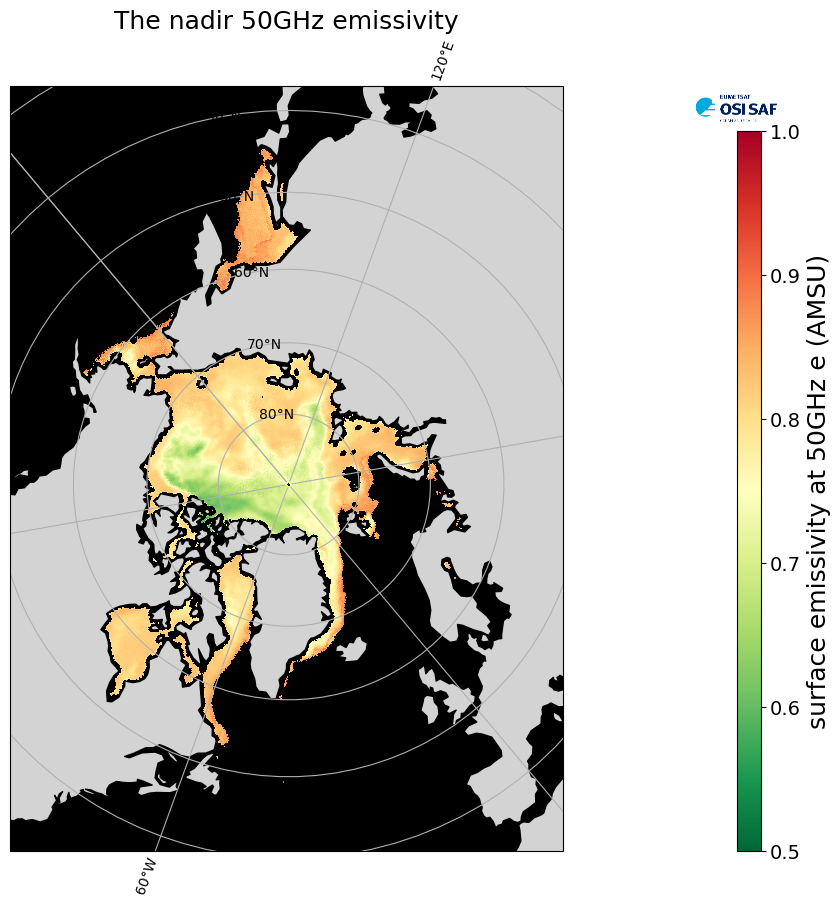

In [9]:
fig = plt.figure(figsize=(12,9))

# request output projection
output_projection=ccrs.NorthPolarStereo(-40)

# Map Emissivity
im = mapping_ice_emi(directory, output_projection, 'e', cmap, title="The nadir 50GHz emissivity")

# Add a colorbar
add_colorbar(im, fig, orientation='vertical', cmap=cmap, label='surface emissivity at 50GHz e (AMSU)')

### Map R coefficient

Let's Map the R coefficient

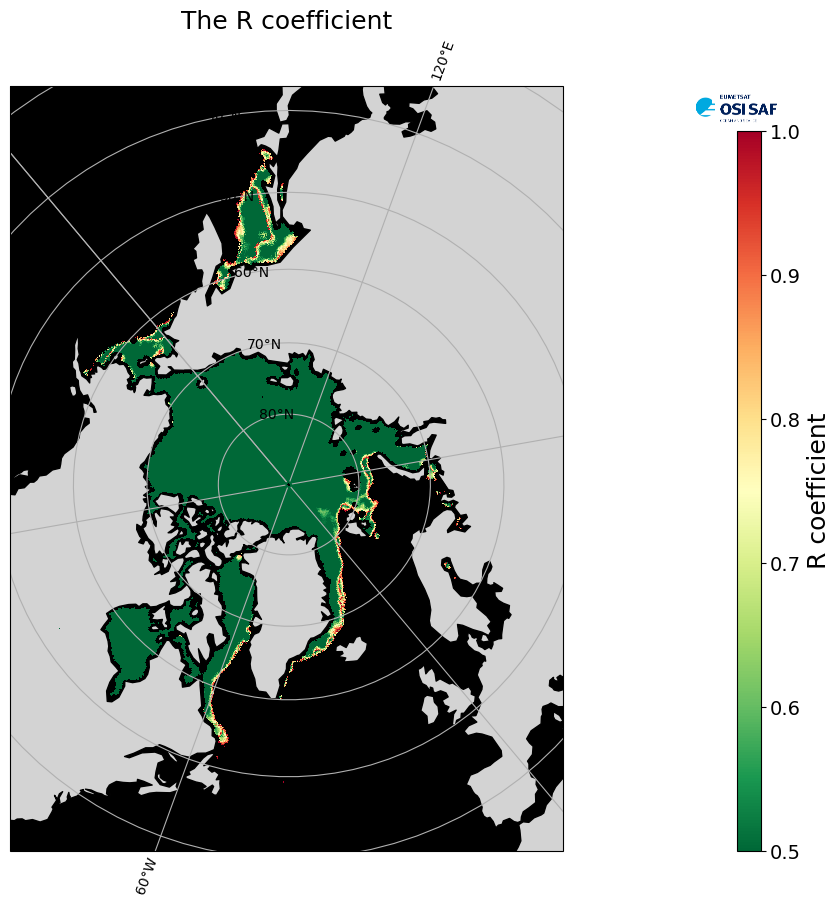

In [10]:
fig = plt.figure(figsize=(12,9))

# request output projection
output_projection=ccrs.NorthPolarStereo(-40)

# Map Emissivity
im = mapping_ice_emi(directory, output_projection, 'R', cmap, title="The R coefficient")

# Add a colorbar
add_colorbar(im, fig, orientation='vertical', cmap=cmap, label='R coefficient')

### Map S coefficient

Let's Map the S coefficient

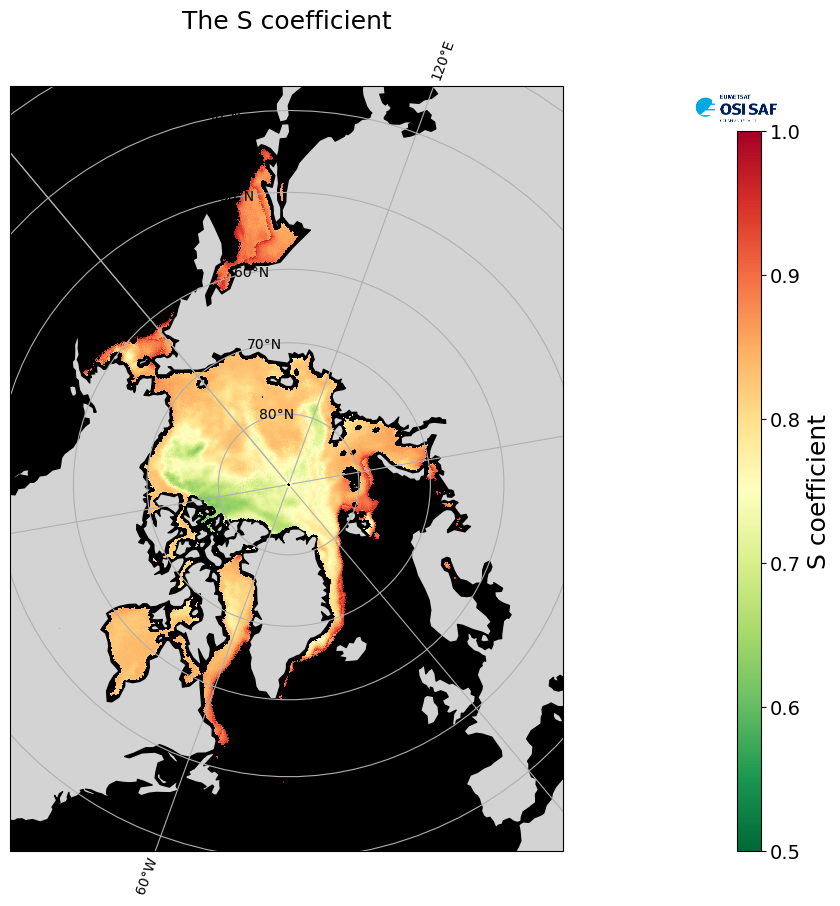

In [11]:
fig = plt.figure(figsize=(12,9))

# request output projection
output_projection=ccrs.NorthPolarStereo(-40)

# Map Emissivity
im = mapping_ice_emi(directory, 
                     output_projection, 
                     'S', 
                     cmap, 
                     title="The S coefficient")

# Add a colorbar
add_colorbar(im, fig, orientation='vertical', cmap=cmap, label='S coefficient')

##
<div class="alert alert-info" role="alert">

## <a id='section1'></a>2. Mapping sea ice emissitivty - Southern Hemisphere
[Back to top](#TOC-TOP)

</div>

Setting directory where to read data files

In [12]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_emissivity', 'sh')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [13]:
#cmap = cmocean.cm.ice
#cmap = cmcrameri.cm.oslo
cmap = mpl_cm.get_cmap('RdYlGn_r')

Sea Ice Drift data has a specific projection. We can explore the netcdf file to find the characteristics.

In [14]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [15]:
nc

<xarray.Dataset> Size: 24MB
Dimensions:                   (xc: 790, yc: 830)
Coordinates:
  * xc                        (xc) float64 6kB -3.945e+06 ... 3.935e+06
  * yc                        (yc) float64 7kB 4.335e+06 ... -3.945e+06
    lon                       (yc, xc) float32 3MB ...
    lat                       (yc, xc) float32 3MB ...
Data variables:
    Polar_Stereographic_Grid  int32 4B ...
    flag                      (yc, xc) float32 3MB ...
    R                         (yc, xc) float32 3MB ...
    S                         (yc, xc) float32 3MB ...
    ev                        (yc, xc) float32 3MB ...
    e                         (yc, xc) float32 3MB ...
    u                         (yc, xc) float32 3MB ...
    teff                      (yc, xc) float32 3MB ...
Attributes: (12/30)
    title:                   The near 50GHz sea ice emissivity
    institution:             The EUMETSAT Ocean and Sea Ice Satellite Applica...
    product_id:              OSI-404
    product_name:            osi_saf_ice_emis
    product_status:          operational
    abstract:                The sea ice surface emissivity is representative...
    ...                      ...
    references:              http://osisaf.met.no\n http://www.osi-saf.org
    history:                 2024-03-04 creation
    product_version:         1.4
    software_version:        5.0.1
    netcdf_version:          3.6.3
    Conventions:             CF-1.5

With Sea Ice Emisivity data file, It is possible to plot 4 types of variables :
* The nadir 50GHz emissivity : e
* The 50GHz vertically polarised emissivity at 50 deg incidence angle : ev
* R coefficient describing the polarisation
* S coefficient describing the nadir emissivity

### Map 50GHz vertically polarised emissivity at 50 deg incidence angle

Let's Map the 50GHz vertically polarised emissivity at 50 deg incidence angle

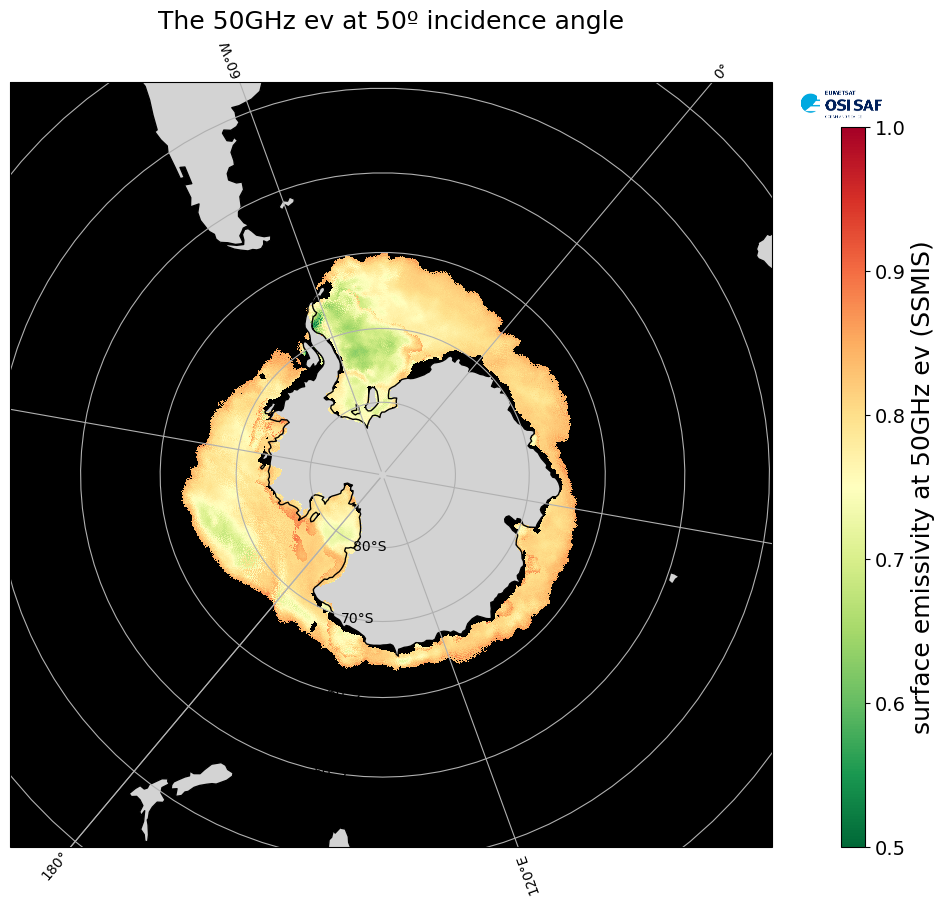

In [16]:
fig = plt.figure(figsize=(12,9))

# request output projection
output_projection=ccrs.SouthPolarStereo(-40)

# Map Emissivity
im = mapping_ice_emi(directory, 
                     output_projection, 
                     'e', 
                     cmap, 
                     title="The 50GHz ev at 50º incidence angle")

# Add a colorbar
add_colorbar(im, fig, orientation='vertical', cmap=cmap, label='surface emissivity at 50GHz ev (SSMIS)')

### Map The nadir 50GHz emissivity

Let's Map the nadir 50GHz emissivity

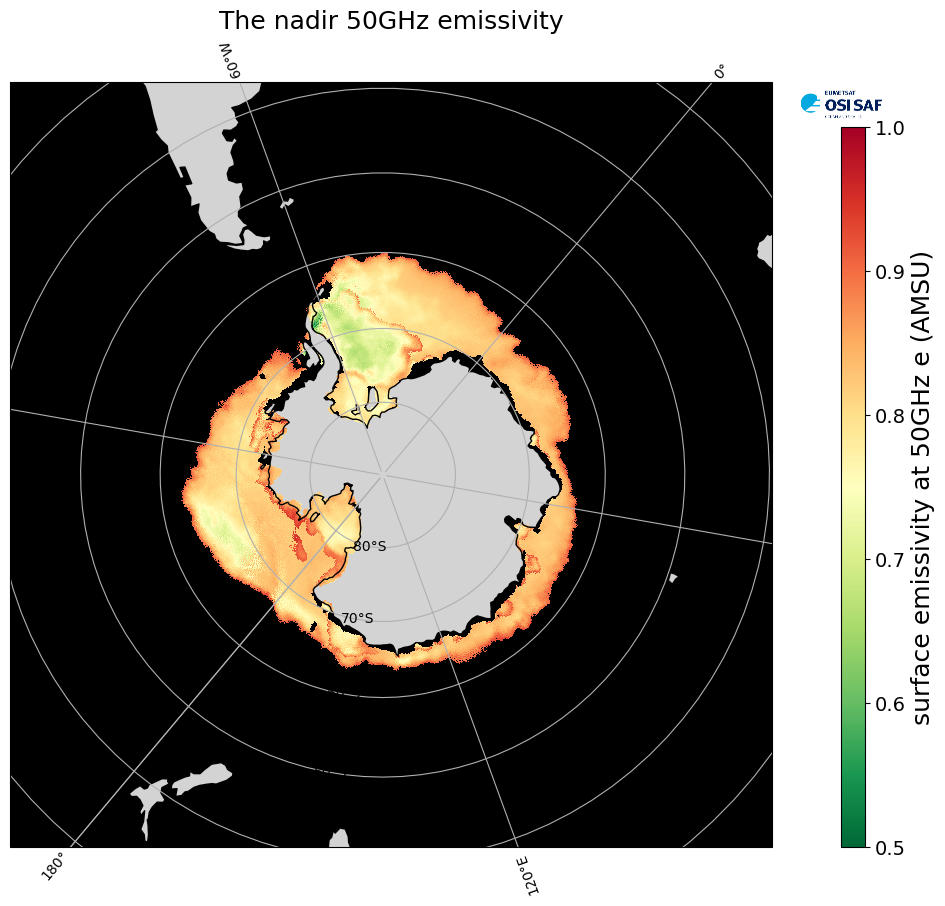

In [17]:
fig = plt.figure(figsize=(12,9))

# request output projection
output_projection=ccrs.SouthPolarStereo(-40)

# Map Emissivity
im = mapping_ice_emi(directory, 
                     output_projection, 
                     'ev', 
                     cmap, 
                     title="The nadir 50GHz emissivity")

# Add a colorbar
add_colorbar(im, fig, orientation='vertical', cmap=cmap, label='surface emissivity at 50GHz e (AMSU)')

### Map R coefficient

Let's Map the R coefficient

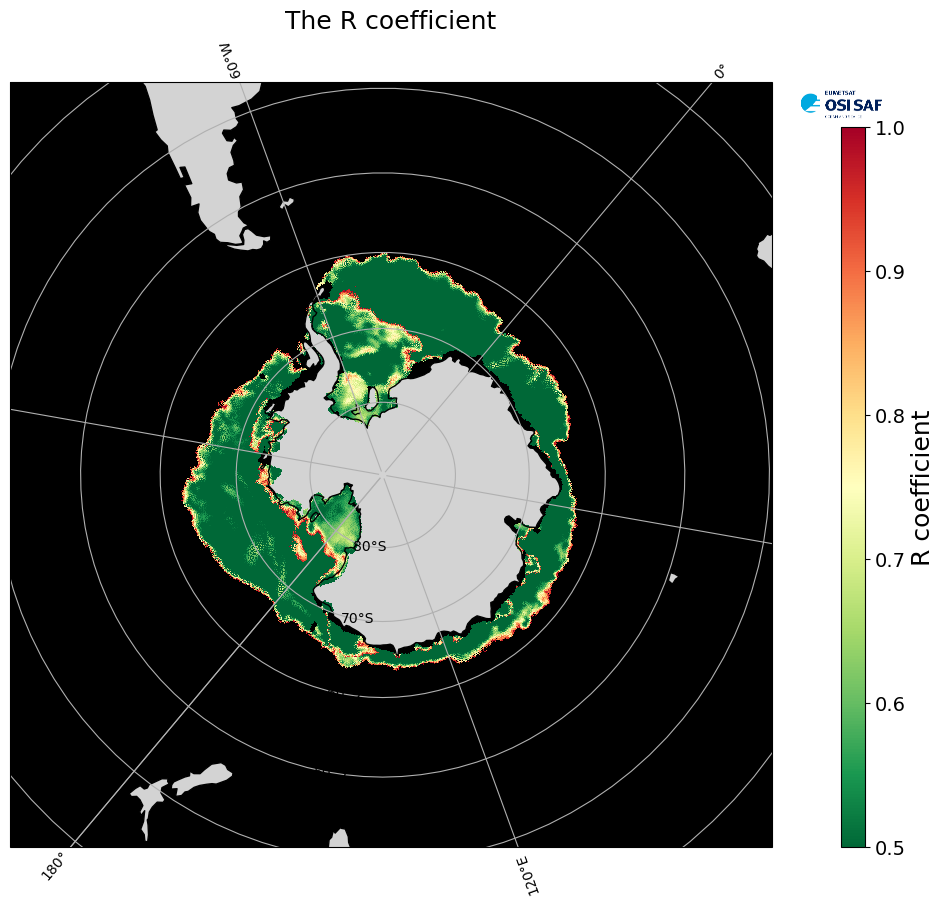

In [18]:
fig = plt.figure(figsize=(12,9))

# request output projection
output_projection=ccrs.SouthPolarStereo(-40)

# Map Emissivity
im = mapping_ice_emi(directory, 
                     output_projection, 
                     'R', 
                     cmap, 
                     title="The R coefficient")

# Add a colorbar
add_colorbar(im, fig, orientation='vertical', cmap=cmap, label='R coefficient')

### Map S coefficient

Let's Map the S coefficient

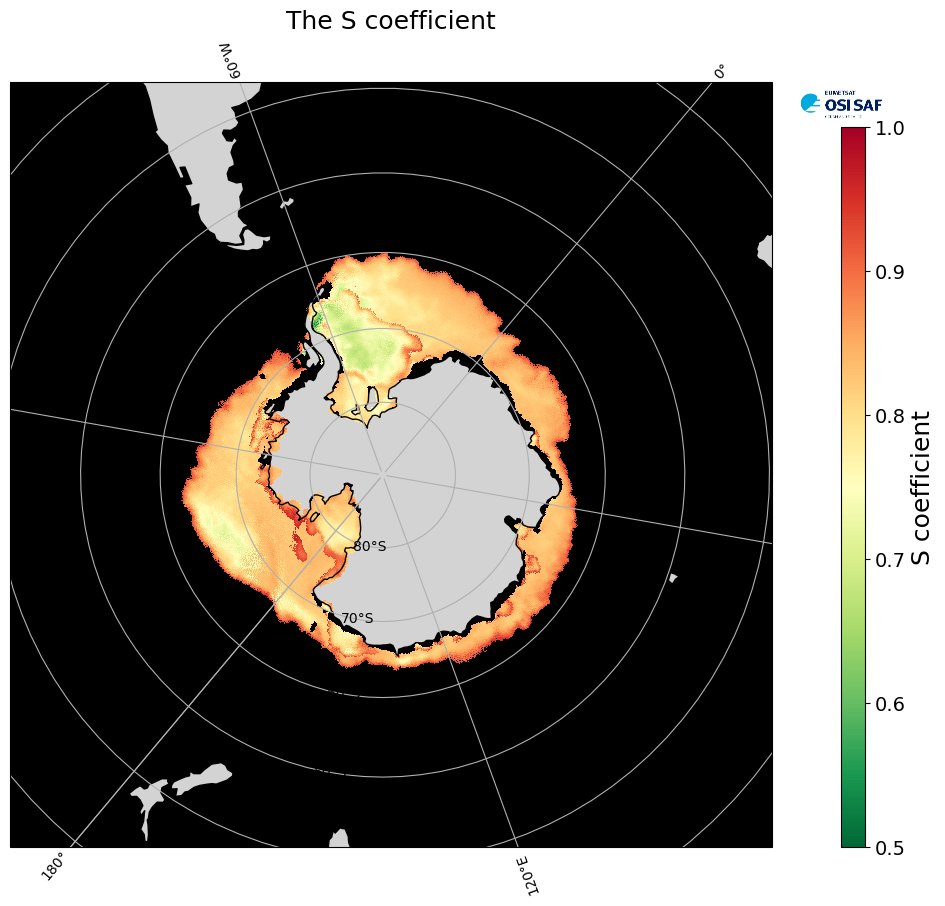

In [19]:
fig = plt.figure(figsize=(12,9))

# request output projection
output_projection=ccrs.SouthPolarStereo(-40)

# Map Emissivity
im = mapping_ice_emi(directory, 
                     output_projection, 
                     'S', 
                     cmap, 
                     title="The S coefficient")

# Add a colorbar
add_colorbar(im, fig, orientation='vertical', cmap=cmap, label='S coefficient')

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3d_OSI_SAF_sea_ice_mapping_Ice_Drift.ipynb" target="_blank"><< Mapping OSI SAF sea ice type</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href=".1_3f_OSI_SAF_sea_ice_plotting_Ice_Index.ipynb" target="_blank">Plotting OSI SAF sea ice index >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>